<center>
<img src="../../img/ods_stickers.jpg">
## <center>Открытый курс по машинному обучению
<center>Автор материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко

# <center> Домашнее задание № 5
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга. Решение

**Задание 1** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%



Решение:
поскольку большинство голосов – 3, тогда у нас $m = 3,~N = 5,~p = 0.7$. Подставляем в формулу из статьи $$ \large \mu = \sum_{i=3}^{5}C_5^i0.7^i(1-0.7)^{5-i} $$
После подставления и проделывания всех операций получим ответ 83.70%

In [1]:
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table   

## Считываем данные
url = 'https://raw.githubusercontent.com/Yorko/mlcourse_open/master/data/credit_scoring_sample.csv'
data = pd.read_csv(url, sep =';')

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']

table = fill_nan(data)

X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". (используйте пример из статьи. Поставьте np.random.seed(0), как это сделано в статье).

In [22]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stats_intervals(stat, alpha):
    boundaries = np.percentile(stat, [alpha / 2, 100 * ( 1 - alpha/2) ])
    return boundaries

np.random.seed(0)
age_means  = [np.mean(sample) for sample in get_bootstrap_samples(X[y == 1].age.values , 1000)]
stats_intervals(age_means , 0.1 )

In [23]:
np.random.seed(0)
age_means  = [np.mean(sample) for sample in get_bootstrap_samples(X[y == 1].age.values , 1000)]
stats_intervals(age_means , 0.1 )

array([ 45.49769479,  46.12700479])

# Логистическая регрессия

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr = LogisticRegression(random_state=5, class_weight= 'balanced')
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра C получилось?



In [37]:
classifier = GridSearchCV(lr, parameters, scoring='roc_auc', cv=skf ).fit(X, y)
best_C  = classifier.best_params_.get('C')
print('Best C for Logistic Regression is  : ', best_C)

Best C for Logistic Regression is  :  0.001


**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%)

In [68]:
#geting the number of the best estimator 
index = list(parameters['C']).index(best_C)
std = classifier.cv_results_['std_test_score'][index]

In [69]:
print('Model is resistant') if std < 0.005  else print('Model is not resisnant')

Model is not resisnant


### Определение влияния признаков

**Задание 5.** Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Также нужно масштабировать все признаки, чтобы можно было корректно сравнивать коэффициенты при них.

In [80]:
from sklearn.preprocessing import StandardScaler 

X_scaled = StandardScaler().fit_transform(X)
lr = LogisticRegression(C=best_C, random_state=17).fit(X_scaled, y )

In [88]:
for feature, coeff in zip (X.columns, lr.coef_[0]):
    print(feature, ' : ', coeff)

age  :  -0.364257417935
NumberOfTime30-59DaysPastDueNotWorse  :  0.418301839819
DebtRatio  :  -0.0195788383485
NumberOfTimes90DaysLate  :  0.260517675614
NumberOfTime60-89DaysPastDueNotWorse  :  -0.016561350322
MonthlyIncome  :  -0.153739145114
NumberOfDependents  :  0.101251004942


In [102]:
weights_df = pd.DataFrame({'feature': X.columns , 'weight': lr.coef_[0], 'absolute_weight': np.abs(lr.coef_[0]) }  )\
            .sort_values(by='absolute_weight')

In [123]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

Text(0.5,1,'Coefficients of features ')

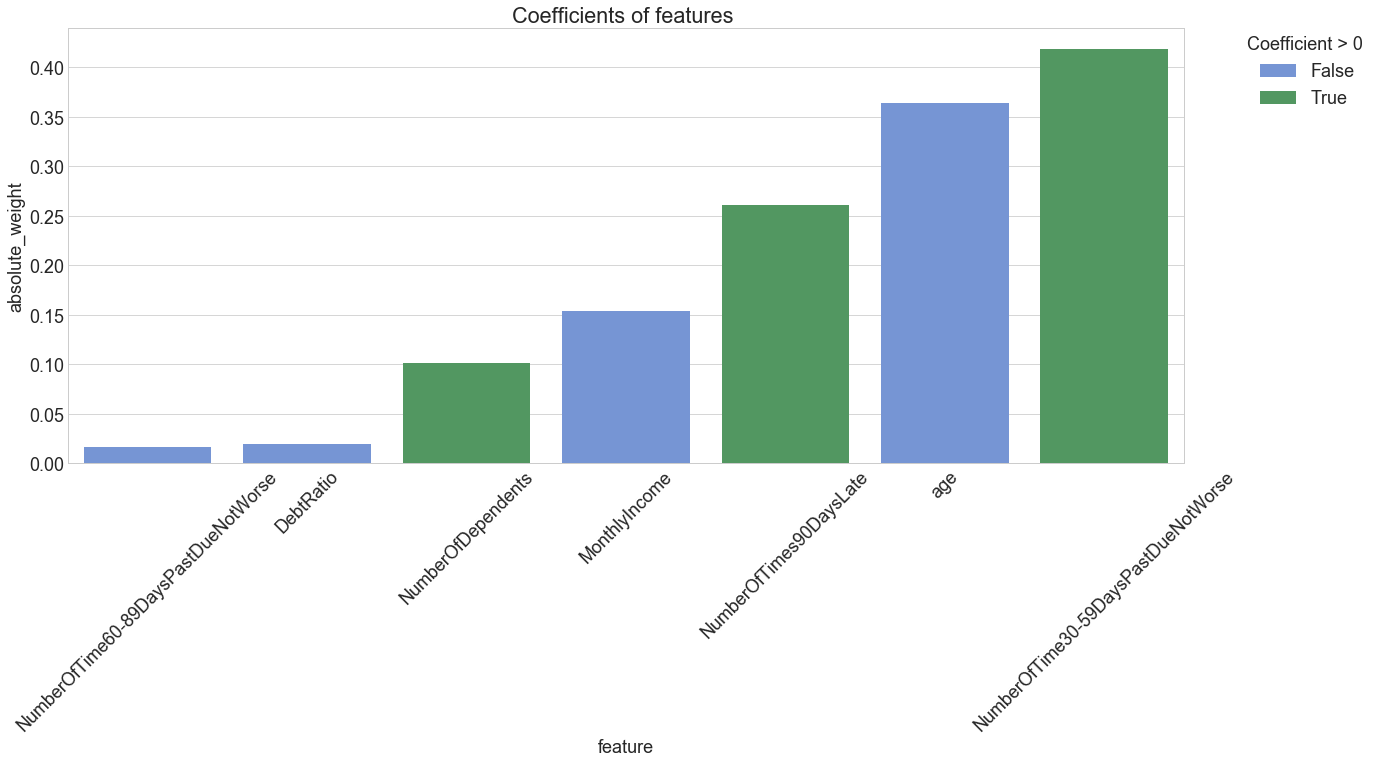

In [184]:
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (20, 8 )

sns.set_style("whitegrid")
colors = ['red', 'green']


sns.barplot(x = weights_df.feature, y = weights_df.absolute_weight , hue = weights_df.weight>0,
            dodge=False, palette=sns.diverging_palette(255, 133, l=60, n=2, center="dark"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.).set_title('Coefficient > 0 ')
#plt.legend().set_title('weight is > 0 ')
plt.xticks(rotation = 45)
plt.title('Coefficients of features ')



Самый важный признак – NumberOfTime30-59DaysPastDueNotWorse.

**Задание 6.** Посчитайте долю влияния `DebtRatio` на предсказание (Реализуйте функцию [softmax](https://en.wikipedia.org/wiki/Softmax_function)).

In [194]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.120046324169


**Задание 7.** 
Давайте посмотрим, как можно интерпретировать влияние наших признаков. Для этого заново оценим логистическую регрессию в абсолютных величинах. После этого посчитайте, во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf)).

In [189]:
lr = LogisticRegression(C=0.001,random_state=5, class_weight= 'balanced')
lr.fit(X, y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,coef,feat
1,0.482349,NumberOfTime30-59DaysPastDueNotWorse
3,0.430314,NumberOfTimes90DaysLate
6,0.115356,NumberOfDependents
4,0.065958,NumberOfTime60-89DaysPastDueNotWorse
2,-0.000011,DebtRatio
5,-0.000011,MonthlyIncome
0,-0.018185,age


In [190]:
np.exp(lr.coef_[0][0]*20)

0.69509577249791366

$\exp^{\beta\delta}$ – во столько раз больше шансы, что клиент не выплатит кредит. Где $\delta$ – на сколько делаем прирост. Например, если увеличить возраст на 20 лет, то шансы, что человек не выплатит кредит, увеличатся в 0.69.

# Случайный лес

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, random_state=42, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

## Делаем опять же стратифицированную k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

**Задание 8.** На сколько доля верных ответов лучшей модели случайного леса выше аналогичной метрики для логистической регрессии на валидации?

In [22]:
%%time
rf_grid_search = GridSearchCV(rf, parameters, scoring ='roc_auc', cv=skf,
                             verbose=True)
rf_grid_search = rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_ - grid_search.best_score_) # Ответ 5

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  7.6min finished


0.039557977245
CPU times: user 7min 33s, sys: 2.28 s, total: 7min 35s
Wall time: 7min 37s


**Задание 9.** Определите, какой признак имеет самое слабое влияние.

In [23]:
independent_columns_names[np.argmin(rf_grid_search.best_estimator_.feature_importances_)]

'NumberOfDependents'

Весь рейтинг важности признаков

In [24]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': rf_grid_search.best_estimator_.feature_importances_}).sort_values(by='coef', ascending=False)

,coef,feat
1,0.302461,NumberOfTime30-59DaysPastDueNotWorse
3,0.278644,NumberOfTimes90DaysLate
4,0.148683,NumberOfTime60-89DaysPastDueNotWorse
0,0.115926,age
2,0.079520,DebtRatio
5,0.060429,MonthlyIncome
6,0.014337,NumberOfDependents


** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

В итоге мы получили, что алгоритм случайно леса лучше сработал для нашей задачи скоринга. Доля верных ответов случайного леса почти на 4% выше. Причинами такого результата стали – небольшое количество признаков и свойства случайного леса как композиции.

Но преимущество логистической регрессии в том, что мы можем проинтерпретировать влияние коэффициентов на результат.

# Бэггинг

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Задание 11.** Следующая задача обучить – бэггинг классификатор. В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Также не забудьте передать параметр валидации cv и random_state=1. Какая лучшая доля верных ответов получилась?

In [27]:
%%time
bg = BaggingClassifier(LogisticRegression(class_weight='balanced'),
                       n_estimators=100, random_state=42)
r_grid_search = RandomizedSearchCV(bg, parameters,  
                                   scoring ='roc_auc', cv=skf, n_iter=20, random_state=1,
                                  verbose=True)
r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.2min finished


CPU times: user 10min 10s, sys: 4.93 s, total: 10min 15s
Wall time: 10min 19s


In [21]:
r_grid_search.best_score_

0.80746778722957357

**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации

Преимущество случайного леса в том, что деревья в композиции слабо коррелируют между собой и это дает максимальную пользу. Аналогично и для бэггинга с логистической регрессией, чем слабее коррелируют между собой одиночные модели, тем выше точность. Поскольку в логистической регрессии практически нет случайности, то мы должны менять наборы признаков и объектов для достижении максимальной декоррелированости наших моделей.